In [158]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

# to import data from LA Data portal
from sodapy import Socrata

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps


import matplotlib.pyplot as plt
import plotly.express as px

In [159]:
afford0 = gpd.read_file('HCIDLA Affordable Housing Projects(2003-Present).geojson')

In [160]:
enviro0 = pd.read_excel ('CAenviroScore.xlsx')

In [161]:
ecol = ['Census Tract',
 'Total Population',
 'California County',
 'ZIP',
 'Nearby City \n(to help approximate location only)',
 'Longitude',
 'Latitude',
 'CES 3.0 Score',
 ' CES 3.0 Percentile',
 'CES 3.0 \nPercentile Range',
 'SB 535 Disadvantaged Community']

In [162]:
enviro = enviro0[ecol]

In [163]:
enla = enviro.loc[enviro['California County'] == 'Los Angeles']

In [164]:
enla = enla.loc[enviro['CES 3.0 Score'] > 0]

In [165]:
enla = enla.rename(columns = {'Census Tract':'CensusTract'})

In [166]:
enla['CensusTract'] = enla['CensusTract'].astype('str')

In [167]:
enla['CensusTract'] = enla['CensusTract'].str.zfill(11)

In [168]:
enla.head()

,CensusTract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community
5,06037204920,2598,Los Angeles,90023,Los Angeles,-118.197497,34.017500,80.726872,99.936940,95-100% (highest scores),Yes
8,06037206050,2146,Los Angeles,90023,Los Angeles,-118.224453,34.029904,79.025293,99.899105,95-100% (highest scores),Yes
14,06037205120,3618,Los Angeles,90023,Los Angeles,-118.211796,34.018755,78.043685,99.823433,95-100% (highest scores),Yes
16,06037291220,3353,Los Angeles,90247,Gardena,-118.286709,33.877139,77.497763,99.798209,95-100% (highest scores),Yes
20,06037239202,4724,Los Angeles,90001,Los Angeles,-118.264977,33.985678,76.043426,99.747761,95-100% (highest scores),Yes


In [169]:
# bringing in census tracts from LA Times
gdf_tracts = gpd.read_file('http://boundaries.latimes.com/1.0/boundary-set/census-tracts-2012/?format=geojson')

In [170]:
gdf_tracts.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,Census Tract (2012),06037101110,06037101110,06037101110-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2594737', 'NAME': '1011.10',...",/1.0/boundary/06037101110-census-tract-2012/,"MULTIPOLYGON (((-118.30229 34.25870, -118.3007..."
1,Census Tract (2012),06037101122,06037101122,06037101122-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2677213', 'NAME': '1011.22',...",/1.0/boundary/06037101122-census-tract-2012/,"MULTIPOLYGON (((-118.30333 34.27354, -118.3031..."
2,Census Tract (2012),06037101210,06037101210,06037101210-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2529724', 'NAME': '1012.10',...",/1.0/boundary/06037101210-census-tract-2012/,"MULTIPOLYGON (((-118.29945 34.25598, -118.2859..."
3,Census Tract (2012),06037101220,06037101220,06037101220-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2516085', 'NAME': '1012.20',...",/1.0/boundary/06037101220-census-tract-2012/,"MULTIPOLYGON (((-118.28592 34.24896, -118.2859..."
4,Census Tract (2012),06037101300,06037101300,06037101300-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2487732', 'NAME': '1013', 'I...",/1.0/boundary/06037101300-census-tract-2012/,"MULTIPOLYGON (((-118.27247 34.23253, -118.2719..."


In [171]:
gdf_tracts = gdf_tracts[['external_id','geometry']]

In [172]:
gdf_tracts.columns=['CensusTract','geometry']

In [173]:
gdf_tracts.head()

,CensusTract,geometry
0,06037101110,"MULTIPOLYGON (((-118.30229 34.25870, -118.3007..."
1,06037101122,"MULTIPOLYGON (((-118.30333 34.27354, -118.3031..."
2,06037101210,"MULTIPOLYGON (((-118.29945 34.25598, -118.2859..."
3,06037101220,"MULTIPOLYGON (((-118.28592 34.24896, -118.2859..."
4,06037101300,"MULTIPOLYGON (((-118.27247 34.23253, -118.2719..."


In [174]:
# do the merge
# first rename the geometry column in enla
enla = enla.rename(columns={'geometry':'geometry_point'})
enla = enla.merge(gdf_tracts,on='CensusTract')

In [175]:
gdf = gpd.GeoDataFrame(enla)

In [176]:
gdf = gdf.to_crs('epsg:3857')

In [177]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   CensusTract                                       2297 non-null   object  
 1   Total Population                                  2297 non-null   int64   
 2   California County                                 2297 non-null   object  
 3   ZIP                                               2297 non-null   int64   
 4   Nearby City 
(to help approximate location only)  2297 non-null   object  
 5   Longitude                                         2297 non-null   float64 
 6   Latitude                                          2297 non-null   float64 
 7   CES 3.0 Score                                     2297 non-null   float64 
 8    CES 3.0 Percentile                               2297 non-null   float64 
 9   

### We want to observe the regions in the 71st percentile of CES scores

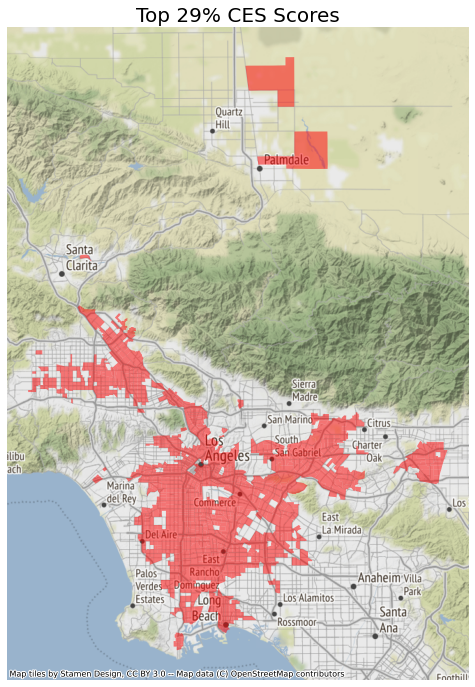

In [178]:
fig, ax = plt.subplots(figsize=(12,12))

gdf[gdf[' CES 3.0 Percentile'] > 71 ].plot(ax=ax,color='r',alpha=0.5)

ax.axis('off')
ax.set_title('Top 29% CES Scores',fontsize=20)
ctx.add_basemap(ax)

In [179]:
afford0.shape

(503, 35)

In [180]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("mymu-zi3s")

# Convert to pandas DataFrame
affords = pd.DataFrame.from_records(results)


In [181]:
affords.shape

(505, 36)

In [182]:
# convert pandas dataframe to geodataframe
affords = gpd.GeoDataFrame(affords, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(affords.longitude, affords.latitude))

In [183]:
# get the layers into a web mercator projection
# reproject to web mercator
affords = affords.to_crs(epsg=3857)

In [184]:
# convert lat/lon to floats
affords.longitude = affords.longitude.astype('float')
affords.latitude = affords.latitude.astype('float')

### We gather the locations of Affordable Housing Projects in LA since 2003

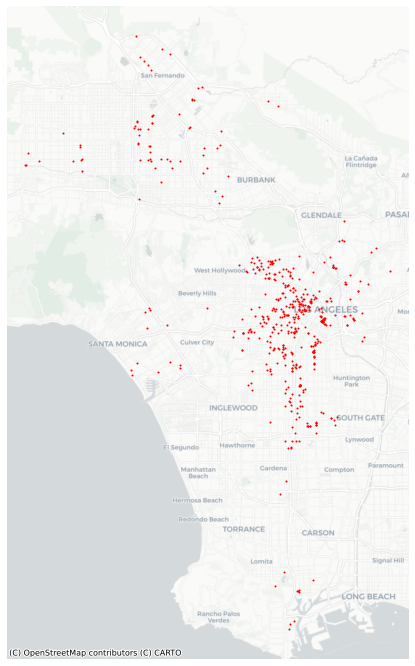

In [185]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

affords.plot(ax=ax,
             color='red',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [186]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = affords.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13202690.869970765
-13154095.45945987
3993428.2023762497
4072393.420646345


### We relate the impose the two datasets of AHP and CalEnviroScores

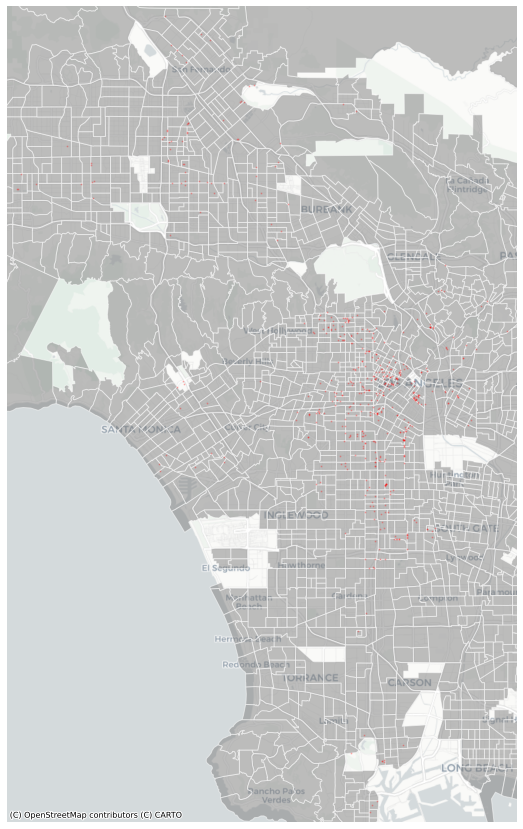

In [187]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(15, 15))

# block groups
gdf.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# arrests
affords.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=1,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [188]:
enla.shape

(2297, 12)

In [189]:
# Do the spatial join
join = gpd.sjoin(affords, gdf, how='left')
join.head()

,apn,project_number,name,development_stage,construction_type,address,council_district,site_cd,community,site_units,...,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community
0,5131020009,05-117217,LEXINGTON APARTMENTS A/B (SITE 11),In-Service,REHAB,"1145 E 24TH ST Los Angeles, CA 90011",9,11,CENTRAL,0,...,4906.0,Los Angeles,90011.0,Los Angeles,-118.257062,34.021842,56.691219,94.463362,90-95%,Yes
1,6071001013,06-117222,WINDWARD APTS (A/B) (SITE 14),In-Service,REHAB,"636 E 108TH ST 1-4 Los Angeles, CA 90059",8,14,CENTURY PALMS/COVE,8,...,4377.0,Los Angeles,90002.0,Los Angeles,-118.261893,33.939705,52.050623,90.793290,90-95%,Yes
2,5544025033,60057,BRICKER,In-Service,ACQUISITION + REHAB,"1671 N WESTERN AVE Los Angeles, CA 90028",13,1,HOLLYWOOD,16,...,4227.0,Los Angeles,90028.0,Los Angeles,-118.311390,34.099977,57.969484,95.333586,95-100% (highest scores),Yes
3,5124011008,07-117233,HDR I & II (SITE 4),In-Service,REHAB,"2375 S SCARFF ST Los Angeles, CA 90007",1,4,UNIVERSITY PARK,20,...,3140.0,Los Angeles,90007.0,Los Angeles,-118.279981,34.035139,49.228476,88.031278,85-90%,Yes
4,5502020005,80050,ALEXANDRIA HOUSE APTS.,In-Service,REHAB,"510 S ALEXANDRIA AVE 1-20 Los Angeles, CA 90020",10,1,KOREATOWN,16,...,2446.0,Los Angeles,90010.0,Los Angeles,-118.298498,34.063573,32.944179,64.800101,60-65%,No


In [190]:
affords_by_gdf = join.CensusTract.value_counts().rename_axis('CensusTract').reset_index(name='affords_count')

### The number of AHP by Census Tract

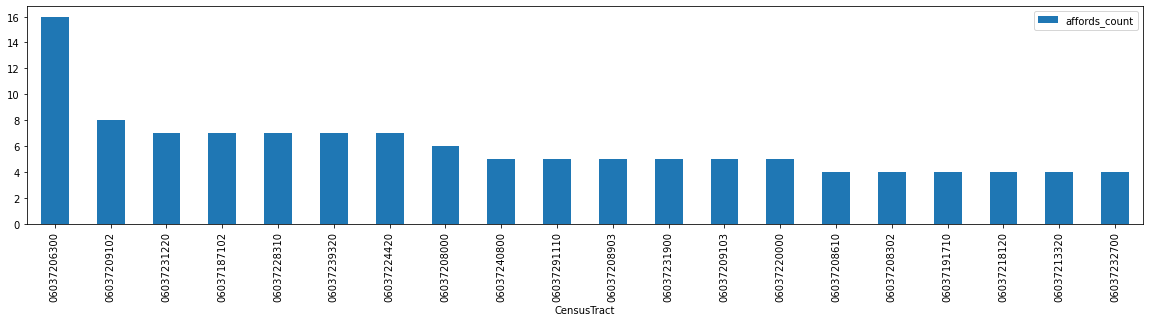

In [191]:
affords_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='CensusTract',
                             y='affords_count')

In [192]:
gdf=gdf.merge(affords_by_gdf,on='CensusTract')

In [193]:
gdf.head()

,CensusTract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,geometry,affords_count
0,06037204920,2598,Los Angeles,90023,Los Angeles,-118.197497,34.017500,80.726872,99.936940,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13158276.842 4030683.113, -13...",1
1,06037239202,4724,Los Angeles,90001,Los Angeles,-118.264977,33.985678,76.043426,99.747761,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13166193.439 4026564.006, -13...",1
2,06037535400,3495,Los Angeles,90002,Los Angeles,-118.231420,33.947117,74.461160,99.659478,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13162778.936 4022534.153, -13...",1
3,06037204600,4101,Los Angeles,90023,Los Angeles,-118.215830,34.036641,73.129679,99.571194,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13160234.952 4032801.051, -13...",2
4,06037227010,4662,Los Angeles,90011,Los Angeles,-118.246997,34.018526,72.675129,99.558582,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13164028.052 4031471.468, -13...",3


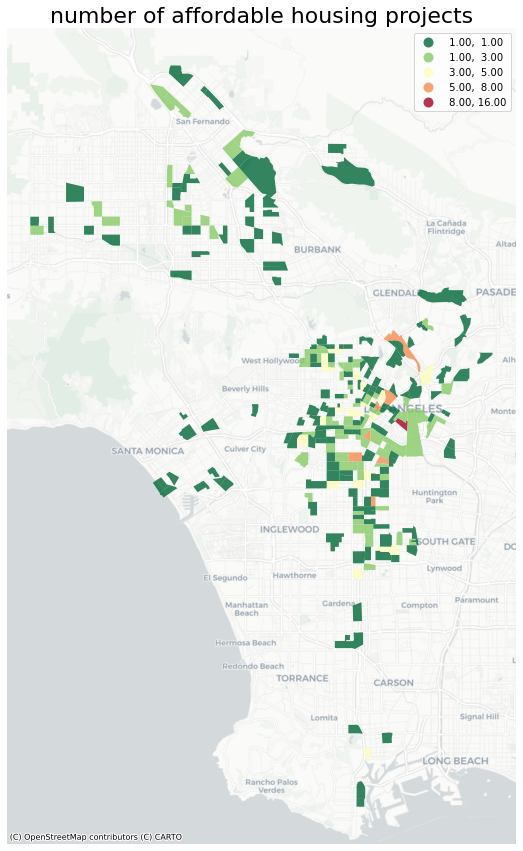

In [194]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='affords_count',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='natural_breaks')

ax.axis('off')
ax.set_title('number of affordable housing projects',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Introducing the use of Spatial Autocorrelation Analysis
This uses K Nearnest Neighbors to find spatial relations

In [195]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
wq.transform = 'r'

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



We find the lag for the affordable housing projects. 

In [196]:
gdf['ahp_counts_lag'] = lps.weights.lag_spatial(wq, gdf['affords_count'])

In [197]:
gdf.sample(10)[['affords_count','ahp_counts_lag']]

,affords_count,ahp_counts_lag
253,1,1.750
247,1,1.750
11,1,2.000
133,1,1.750
112,2,2.250
127,1,2.250
161,1,2.375
59,3,2.500
157,4,2.125
6,2,2.750


In [198]:
gdf['lag_diff'] = gdf['affords_count'] - gdf['ahp_counts_lag']

In [199]:
gdf.sort_values(by='lag_diff')

,CensusTract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,geometry,affords_count,ahp_counts_lag,lag_diff
178,06037208902,2339,Los Angeles,90017,Los Angeles,-118.272372,34.056446,44.045291,81.611805,80-85%,Yes,"MULTIPOLYGON (((-13166277.485 4036510.169, -13...",1,4.000,-3.000
90,06037231100,3350,Los Angeles,90007,Los Angeles,-118.276558,34.015248,53.311120,91.827469,90-95%,Yes,"MULTIPOLYGON (((-13167174.943 4030642.421, -13...",1,3.875,-2.875
69,06037207301,4521,Los Angeles,90013,Los Angeles,-118.251617,34.046537,55.645438,93.618363,90-95%,Yes,"MULTIPOLYGON (((-13164323.049 4034580.428, -13...",1,3.875,-2.875
73,06037209200,2785,Los Angeles,90017,Los Angeles,-118.261082,34.054209,54.951808,93.227393,90-95%,Yes,"MULTIPOLYGON (((-13165236.871 4035819.278, -13...",1,3.750,-2.750
211,06037207502,2589,Los Angeles,90071,Los Angeles,-118.253084,34.052707,39.243945,74.801362,70-75%,No,"MULTIPOLYGON (((-13164481.234 4035932.005, -13...",1,3.500,-2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,06037224420,2369,Los Angeles,90007,Los Angeles,-118.276904,34.031650,53.358410,91.865305,90-95%,Yes,"MULTIPOLYGON (((-13166962.768 4033038.133, -13...",7,1.750,5.250
103,06037209102,5267,Los Angeles,90017,Los Angeles,-118.267521,34.055186,52.002369,90.730231,90-95%,Yes,"MULTIPOLYGON (((-13165883.192 4036040.971, -13...",8,2.625,5.375
31,06037187102,3254,Los Angeles,90039,Los Angeles,-118.251456,34.109048,61.184220,96.733510,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13164832.558 4043554.761, -13...",7,1.500,5.500
21,06037239320,3444,Los Angeles,90003,Los Angeles,-118.271738,33.978568,63.305613,97.603733,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13166193.550 4025502.144, -13...",7,1.250,5.750


In [200]:
gdf_donut = gdf.sort_values(by='lag_diff').head(1)
gdf_donut

,CensusTract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,geometry,affords_count,ahp_counts_lag,lag_diff
178,06037208902,2339,Los Angeles,90017,Los Angeles,-118.272372,34.056446,44.045291,81.611805,80-85%,Yes,"MULTIPOLYGON (((-13166277.485 4036510.169, -13...",1,4.0,-3.0


In [201]:
gdf_diamond = gdf.sort_values(by='lag_diff').tail(1)
gdf_diamond

,CensusTract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,geometry,affords_count,ahp_counts_lag,lag_diff
16,06037206300,7540,Los Angeles,90013,Los Angeles,-118.243213,34.041111,65.941058,98.448733,95-100% (highest scores),Yes,"MULTIPOLYGON (((-13163575.650 4034612.267, -13...",16,1.875,14.125


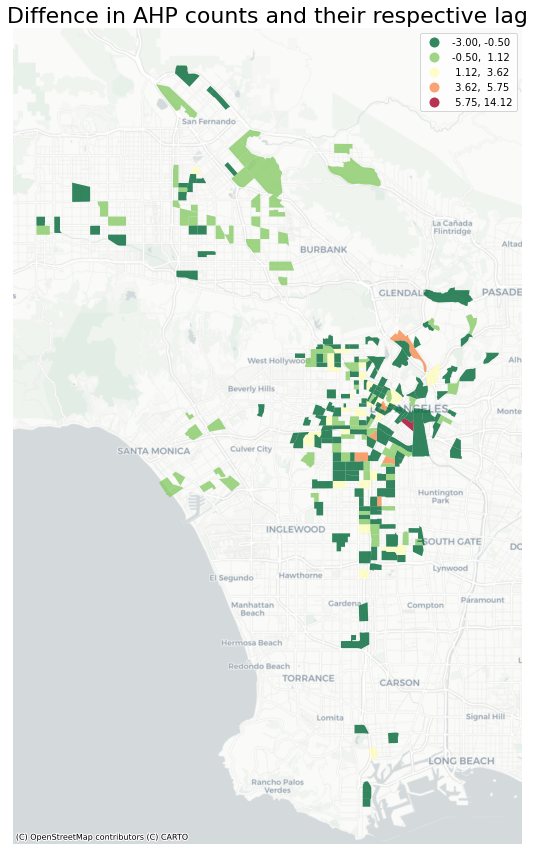

In [202]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
gdf.plot(ax=ax,
         figsize=(15,15),
         column='lag_diff',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='natural_breaks')

ax.axis('off')
ax.set_title('Diffence in AHP counts and their respective lag',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

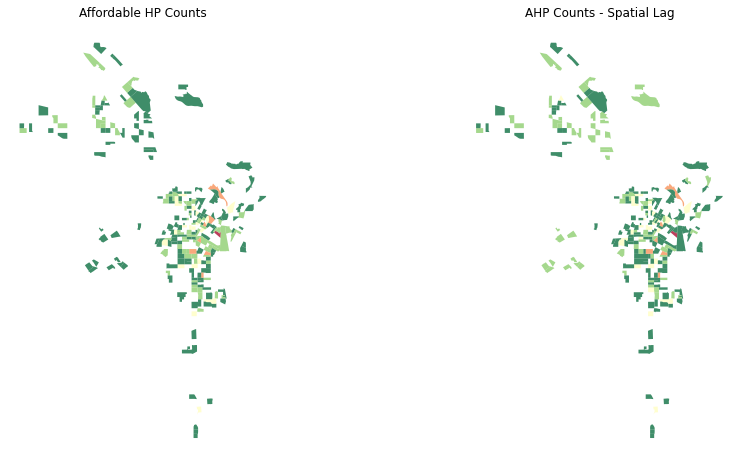

In [203]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
gdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='affords_count', 
         cmap='RdYlGn_r', 
         scheme='natural_breaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Affordable HP Counts")

# spatial lag map on the right
gdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='lag_diff', 
         cmap='RdYlGn_r', 
         scheme='natural_breaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("AHP Counts - Spatial Lag")

plt.show()

In [204]:
gdf_web = gdf.to_crs('EPSG:4326')

In [205]:
minx, miny, maxx, maxy = gdf_web.geometry.total_bounds
center_lat_gdf_web = (maxy-miny)/2+miny
center_lon_gdf_web = (maxx-minx)/2+minx

In [206]:
# some stats
gdf_web.ahp_counts_lag.describe()

count    265.000000
mean       1.951887
std        0.630409
min        1.000000
25%        1.500000
50%        1.875000
75%        2.250000
max        4.250000
Name: ahp_counts_lag, dtype: float64

In [207]:
median = gdf_web.ahp_counts_lag.median()

### Knowing the median as the result of KNN we can assign a legend key

In [208]:
fig = px.choropleth_mapbox(gdf_web, 
                     geojson=gdf_web.geometry, # the geometry column
                     locations=gdf_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='ahp_counts_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['affords_count','ahp_counts_lag'],
                     center = {"lat": center_lat_gdf_web, "lon": center_lon_gdf_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'arrests_per_1000_lag':'Arrests per 1000 (Spatial Lag)',
                             'arrests_per_1000':'Arrests per 1000',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

### Moran I
Moran's I statistic: 0.038
This means high values are closer to high values or low values are closer to low values

In [209]:
y = gdf.affords_count
moran = Moran(y, wq)
moran.I

0.03808007073065676

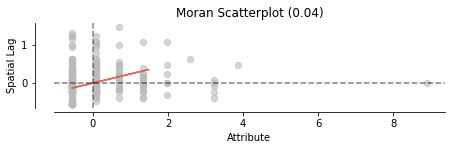

In [210]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.



(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43107d3700>)

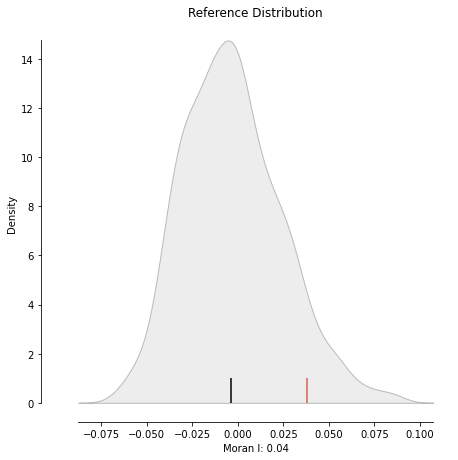

In [211]:
plot_moran_simulation(moran,aspect_equal=False)

The p value from the p simulation is .069. This is unfortunate because it means we are the conclusion of whatever significance value we choose. If I go with a 0.1 significance value, we have enough evidence to believe that the map displays more a spatial pattern than if the data was randomly distributed. 

In [212]:
moran.p_sim

0.072

In [213]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

#### We observe that the most abundant points are HH.
High counts of affordable housing projects near high affordable housing projects

The colored dots are all statistically significant for their quadrant.

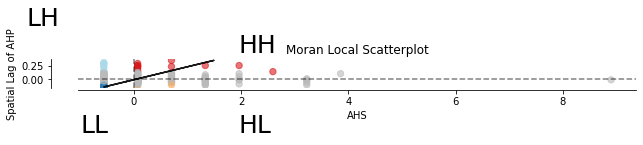

In [214]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("AHS")
ax.set_ylabel('Spatial Lag of AHP')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

Here the significant regions are shown imposed over a mapping and colored. 

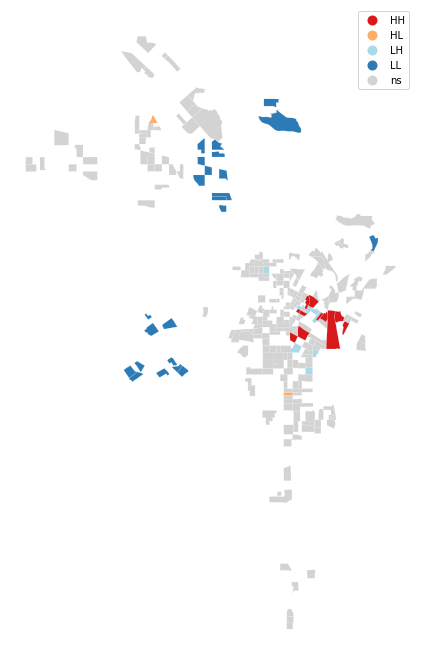

In [215]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, ax=ax)
plt.show()

#### It is shown that HH and LL are dominant in statistical significance representation.
This means high AHP counts surround each other, while low AHP counts surround low AHP count areas.

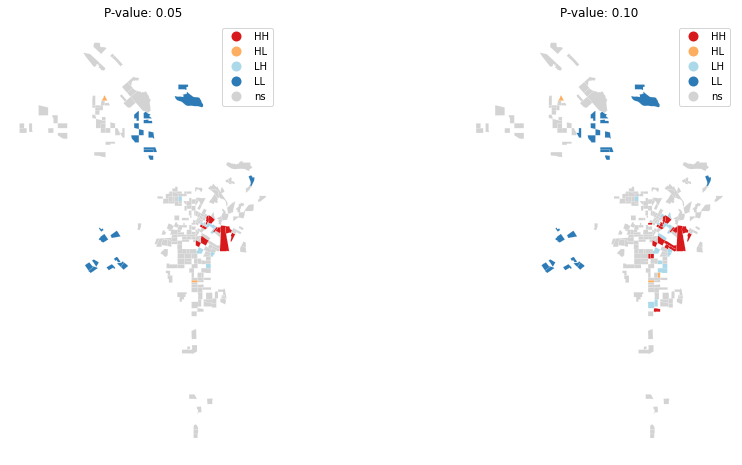

In [216]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# regular count map on the left
lisa_cluster(lisa, gdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf, p=0.10, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.10")

plt.show()

While there is question of statistical significance, the data presents evidence for there being correlation of affordable housing projects surrouding each other in high CalEnviroScore regions. This is important because now we know the tendencies of where AHP are created and how that relates to Cal EnviroScores. We made sure to segment our analysis to the regions of interest, that being high CalEnviroScores. This allows us to quanitify our urban research on on AHPs in Los Angeles through autospatial analysis.

Richard - Statistician, coding, mapping

Haley - Data expert, interpretations, storytelling